In [1]:
import keras
import numpy as np
import scipy.io
from pathlib import Path
import os
from glob import glob
from skimage import data, io, feature, color, exposure
import numpy as np
import cv2

from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt

Using TensorFlow backend.


## Open labels

In [2]:
path = 'C:\\Users\\Rodolfo\\Documents\\algoritmos-git\\custom_cnn\\Data\\Processados\\'

In [3]:
y_train = np.load(Path(path,'y_train.npy'))
y_test = np.load(Path(path, 'y_test.npy'))
y_train = np.expand_dims(y_train, axis=1)
y_test = np.expand_dims(y_test, axis=1)

In [4]:
from keras.utils import np_utils
# one-hot encode the labels
num_classes = len(np.unique(y_train))
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [5]:
y_train

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [6]:
y_test

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

# Open data

In [7]:
path = Path(path, '100_100')
X_train_1 = np.load(Path(path, 'X_train_1.npy'))
X_train_2 = np.load(Path(path, 'X_train_2.npy'))
X_test_1 = np.load(Path(path, 'X_test_1.npy'))
X_test_2 = np.load(Path(path, 'X_test_2.npy'))
print(X_train_1.shape)
print(X_train_2.shape)
print(X_test_1.shape)
print(X_test_2.shape)

(2200, 100, 100)
(2200, 100, 100)
(1000, 100, 100)
(1000, 100, 100)


In [8]:
# Empilhei uma imagem abaixo da outra
X_train_ = np.append(X_train_1, X_train_2, axis=1)
X_train_.shape

(2200, 200, 100)

In [9]:
# Empilhei uma imagem abaixo da outra
X_test_ = np.append(X_test_1, X_test_2, axis=1)
X_test_.shape

(1000, 200, 100)

In [10]:
def plt_img(img_matrix, title='Image', normalize=False):
    if normalize:
        plt.imshow(img_matrix, vmin=np.min(img_matrix), vmax=np.max(img_matrix), cmap='gray')
    else:
        io.imshow(img_matrix)
    plt.title(title)
    plt.show()

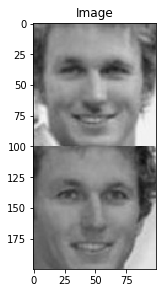

In [11]:
plt_img(X_train_[0]) # train: instance 1: path_pair_id_1_cropped and path_pair_id_2_cropped

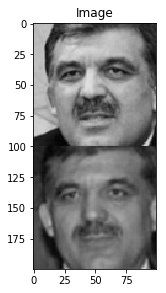

In [12]:
plt_img(X_test_[0]) # test: instance 1: path_pair_id_1_cropped and path_pair_id_2_cropped

### Shape desejado: x_train shape: (45000, 32, 32, 3) -> n_obs, n_row, n_col, n_chan

In [13]:
n_obs, n_row, n_col = X_train_.shape
n_chan=1
X_train = np.zeros((n_obs, n_row, n_col, n_chan))
X_train.shape

(2200, 200, 100, 1)

In [14]:
X_train[:,:,:,0]=X_train_
X_train.shape

(2200, 200, 100, 1)

In [15]:
X_train[:,:,:,0].shape

(2200, 200, 100)

In [16]:
n_obs, n_row, n_col = X_test_.shape
n_chan=1
X_test = np.zeros((n_obs, n_row, n_col, n_chan))
X_test.shape

(1000, 200, 100, 1)

In [17]:
X_test[:,:,:,0]=X_test_
X_test.shape

(1000, 200, 100, 1)

In [18]:
X_test[:,:,:,0].shape

(1000, 200, 100)

# Shuffle X_train

In [19]:
arr = np.arange(y_train.shape[0])
np.random.shuffle(arr)
X_train = X_train[arr,:,:,:]
y_train = y_train[arr]

### 3. Rescale the Images by Dividing Every Pixel in Every Image by 255

In [20]:
# rescale [0,255] --> [0,1]
X_train = X_train.astype('float32')/255
X_test = X_test.astype('float32')/255

### 4.  Break Dataset into Training, Testing, and Validation Sets

In [21]:
# break training set into training and validation sets
(X_train, X_valid) = X_train[:1800], X_train[1800:]
(y_train, y_valid) = y_train[:1800], y_train[1800:]

# print shape of training set
print('x_train shape:', X_train.shape)

# print number of training, validation, and test images
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')
print(X_valid.shape[0], 'validation samples')

x_train shape: (1800, 200, 100, 1)
1800 train samples
1000 test samples
400 validation samples


In [22]:
n_chan

1

In [23]:
n_obs, n_row, n_col, n_chan = X_train.shape

In [24]:
print(n_obs, n_row, n_col, n_chan)

1800 200 100 1


### 5. Define the Model Architecture 

In [25]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# "valid" means no padding. "same" results in padding
model = Sequential()
model.add(Conv2D(filters=16, kernel_size=2, padding='valid', activation='relu', strides=(1,1), input_shape=(n_row, n_col, n_chan)))
model.add(MaxPooling2D(pool_size=2, strides=(1,1)))
model.add(Conv2D(filters=32, kernel_size=2, padding='valid', activation='relu', strides=(2,2)))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=64, kernel_size=2, padding='valid', activation='relu', strides=(1,1)))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=128, kernel_size=2, padding='valid', activation='relu', strides=(1,1)))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(500, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(num_classes, activation='softmax'))

model.summary()






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 199, 99, 16)       80        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 198, 98, 16)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 99, 49, 32)        2080      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 49, 24, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 48, 23, 64)        8256      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 24, 11, 64)        0         
______________________

### 6. Compile the Model 

In [26]:
# compile the model
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', 
                  metrics=['accuracy'])

### 7. Train the Model 

In [27]:
model_path = 'model_10.weights.best.hdf5'

In [28]:
from keras.callbacks import ModelCheckpoint   

# train the model

checkpointer = ModelCheckpoint(filepath=model_path, verbose=1, 
                               save_best_only=True)
hist = model.fit(X_train, y_train, batch_size=32, epochs=20,
          validation_data=(X_valid, y_valid), callbacks=[checkpointer], 
          verbose=2, shuffle=True)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 1800 samples, validate on 400 samples
Epoch 1/20





 - 36s - loss: 0.7040 - acc: 0.4861 - val_loss: 0.6918 - val_acc: 0.5300

Epoch 00001: val_loss improved from inf to 0.69176, saving model to model_10.weights.best.hdf5
Epoch 2/20
 - 35s - loss: 0.6942 - acc: 0.5011 - val_loss: 0.6914 - val_acc: 0.5300

Epoch 00002: val_loss improved from 0.69176 to 0.69138, saving model to model_10.weights.best.hdf5
Epoch 3/20
 - 35s - loss: 0.6951 - acc: 0.5033 - val_loss: 0.6940 - val_acc: 0.4700

Epoch 00003: val_loss did not improve from 0.69138
Epoch 4/20
 - 35s - loss: 0.6944 - acc: 0.4978 - val_loss: 0.6935 - val_acc: 0.4725

Epoch 00004: val_loss did not improve from 0.69138
Epoch 5/20
 - 36s - loss: 0.6939 - acc: 0.5061 - val_loss: 0.6943 - val_acc: 0.4700

Epoch 00005: val_loss did not improve from 0.69138
Epoch 6/20
 - 41s - loss: 0.6926 - acc: 0.5150 - val_loss: 0.6907 - val_acc: 0.

In [29]:
model_path

'model_10.weights.best.hdf5'

### 8. Load the Model with the Best Validation Accuracy

In [30]:
# load the weights that yielded the best validation accuracy
model.load_weights(model_path)

### 9. Calculate Classification Accuracy on Test Set

In [31]:
# evaluate and print test accuracy
score = model.evaluate(X_test, y_test, verbose=0)
print('\n', 'Test accuracy:', score[1])


 Test accuracy: 0.532


In [32]:
model.predict(X_test)

array([[0.6088058 , 0.39119425],
       [0.43453124, 0.5654687 ],
       [0.52861357, 0.4713864 ],
       ...,
       [0.54968345, 0.4503165 ],
       [0.5514735 , 0.44852647],
       [0.50234234, 0.4976577 ]], dtype=float32)

In [33]:
y_test

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [34]:
model_path

'model_10.weights.best.hdf5'